In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #01 - Function Fitting

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using function fitting. The code
that was created is designed to read in the observations, create and
overlay a latitude/longitude grid and plot the data based on what grid
points fall within our radii of influence. The code for this assignment
was created by Mark McGarry Jr. with assistance and sanity checking by Alec
Sczepanski and Joseph Gufford. Cartopy code was supplied by Dr. Jared Marquis
who created this assignment. R.I.P. my brain (which oozed out of my ears while doing
this assignment).

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [1]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
from io import StringIO

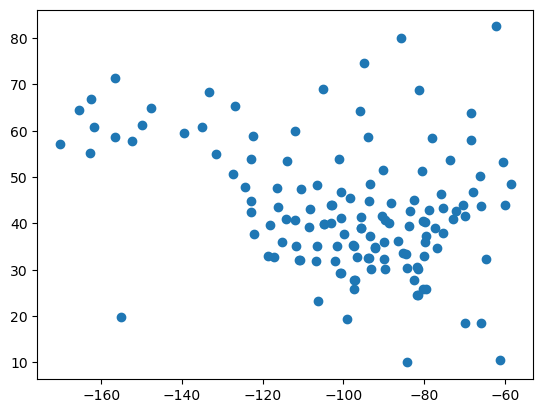

In [2]:
### Read in observations ###

with open("C:/Users/Mark McGarry/Documents/ATSC_528/RAOBs_201903131200.txt") as file:
    data = file.read()

data = np.genfromtxt(StringIO(data), delimiter=",")
data = data[:,1:]

latitude = data[:,0]
longitude = data[:,1]
Height = data[:,2]
plt.scatter(longitude, latitude)

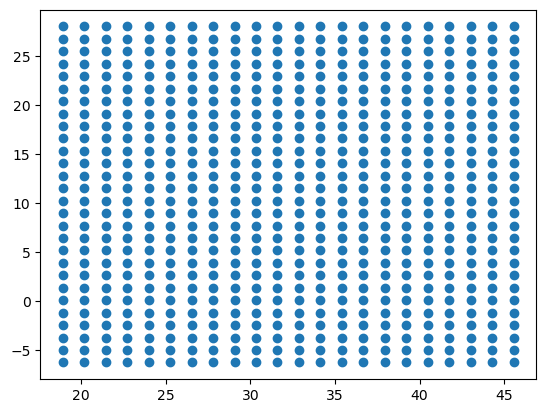

In [3]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x = np.arange(22)*(1.27)+18.9
y = np.arange(28)*(1.27)-6.3

X,Y = np.meshgrid(x,y)
plt.scatter(X,Y)

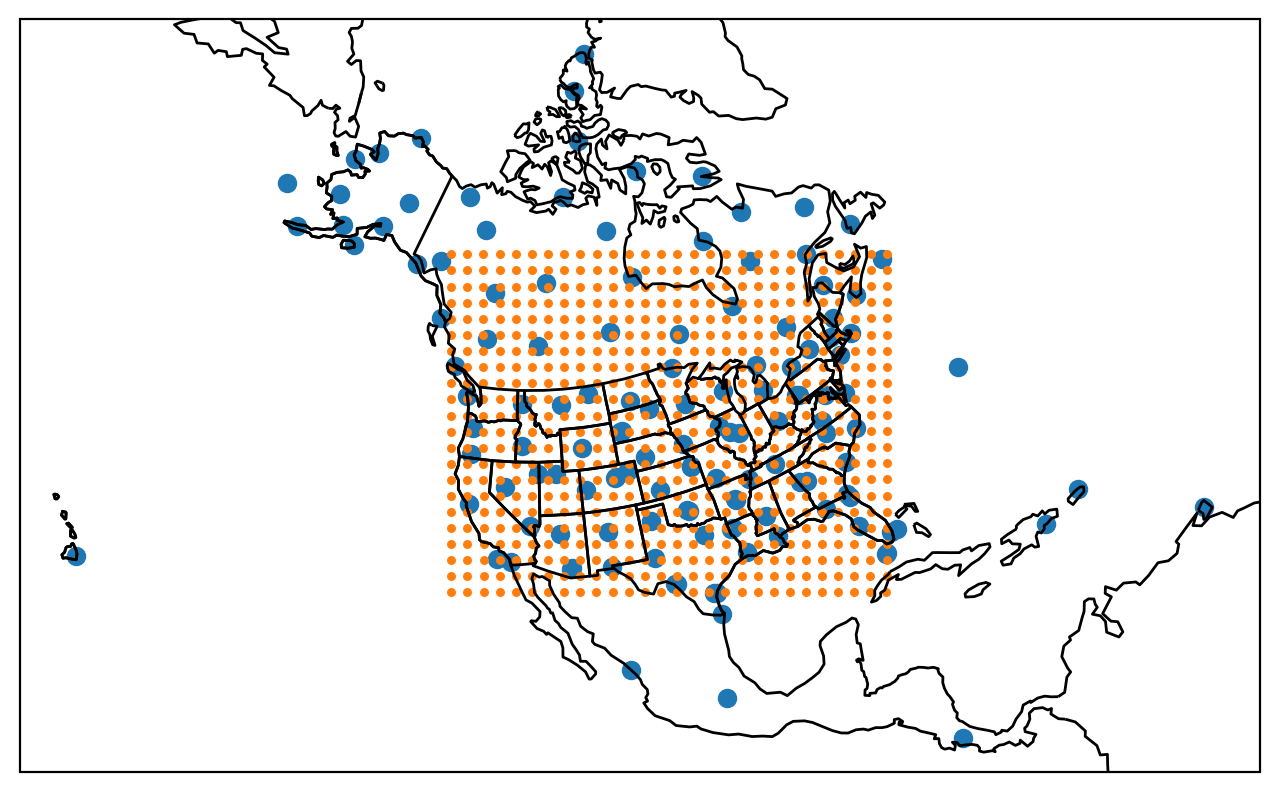

In [6]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)###
#sigma = (1+np.sin(np.radians(60)))/(1+np.sin(np.radians(data[:,0])))

rho = 637100000 #radius of Earth in cm
m = 1/15000000
phi_O = 60*(np.pi / 180)
lam_O = -115*(np.pi / 180)

lat_rad = latitude*(np.pi / 180)
lon_rad = longitude*(np.pi / 180)

sigma = (1 + np.sin(phi_O)) / (1 + np.sin(lat_rad))

r = m * (rho * sigma * np.cos(lat_rad))
x_obs = r * (np.cos(lon_rad - lam_O))
y_obs = r * (np.sin(lon_rad - lam_O))

Ob_Lat = ((np.pi/2) - 2*np.arctan((np.sqrt((x_obs / m)**2+(y_obs / m)**2))/(rho*(1+np.sin(phi_O)))))*(180/np.pi)
Ob_Lon =  (np.arctan((y_obs/m)/(x_obs/m)))*(180/np.pi) - 115
Lat_Grid = ((np.pi/2) - 2*np.arctan((np.sqrt((X / m)**2+(Y / m)**2))/(rho*(1+np.sin(phi_O)))))*(180/np.pi)
Lon_Grid =  (np.arctan((Y/m)/(X/m)))*(180/np.pi) - 115


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

plt.scatter(Ob_Lon, Ob_Lat, transform = ccrs.PlateCarree())
plt.scatter(Lon_Grid, Lat_Grid, transform = ccrs.PlateCarree(), s = 5)

In [8]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###
ROI1 = 10
ROI2 = 20
ROI3 = 6

#Output Arrays
Delobs6 = np.zeros((28,22))
Delobs10 = np.zeros((28,22))
Delobs20 = np.zeros((28,22))
Output6 = np.zeros((28,22))
Output10 = np.zeros((28,22))
Output20 = np.zeros((28,22))

#For ROI = 10 cm
for i in range(22):
    for j in range(28):
        xd = X[j,i] - x_obs
        yd = Y[j,i] - y_obs
        td = np.sqrt(((xd)**2)+((yd**2)))
        a = np.where(td <= ROI1)
        b = np.where(td <= ROI2)
        Delobs10[j,i] = len(a[0])
        Delobs20[j,i] = len(b[0])
        xk = xd[a[0]]
        yk = yd[a[0]]
        hk = Height[a[0]]
        AR = np.zeros((6,6))
        AO = np.zeros(6)
        for k in range(len(xk)):
            E1 = 1
            E2 = xk[k]
            E3 = yk[k]
            E4 = xk[k]**2
            E5 = yk[k]**2
            E6 = xk[k]*yk[k]
            Mnew = np.array([[E1, E2, E3, E4, E5, E6]])
            Mt = np.transpose(Mnew)
            AR += (Mnew*Mt)
            f0 = hk[k]
            xkf0 = xk[k]*f0
            ykf0 = yk[k]*f0
            xk2f0 = (xk[k]**2)*f0
            yk2f0 = (yk[k]**2)*f0
            xkykf0 = xk[k]*yk[k]*f0
            AO += (np.array([f0, xkf0, ykf0, xk2f0, yk2f0, xkykf0]))
        Mavg = AR / Delobs10[j,i]
        Mavg = np.matrix(Mavg)
        Mavg2 = AO / Delobs10[j,i]
        Mavg2 = np.matrix(Mavg2)
        MO = np.transpose(Mavg2)
        MR = np.linalg.inv(Mavg)
        MC = MR*MO
        Output10[j,i] = MC[0,0]
#For ROI = 20 cm
for i in range(22):
    for j in range(28):
        xd = X[j,i] - x_obs
        yd = Y[j,i] - y_obs
        td = np.sqrt(((xd)**2)+((yd**2)))
        a = np.where(td <= ROI1)
        b = np.where(td <= ROI2)
        Delobs10[j,i] = len(a[0])
        Delobs20[j,i] = len(b[0])
        xk = xd[b[0]]
        yk = yd[b[0]]
        hk = Height[b[0]]
        AR = np.zeros((6,6))
        AO = np.zeros(6)
        for k in range(len(xk)):
            E1 = 1
            E2 = xk[k]
            E3 = yk[k]
            E4 = xk[k]**2
            E5 = yk[k]**2
            E6 = xk[k]*yk[k]
            Mnew = np.array([[E1, E2, E3, E4, E5, E6]])
            Mt = np.transpose(Mnew)
            AR += (Mnew*Mt)
            f0 = hk[k]
            xkf0 = xk[k]*f0
            ykf0 = yk[k]*f0
            xk2f0 = (xk[k]**2)*f0
            yk2f0 = (yk[k]**2)*f0
            xkykf0 = xk[k]*yk[k]*f0
            AO += (np.array([f0, xkf0, ykf0, xk2f0, yk2f0, xkykf0]))
        Mavg = AR / Delobs20[j,i]
        Mavg = np.matrix(Mavg)
        Mavg2 = AO / Delobs20[j,i]
        Mavg2 = np.matrix(Mavg2)
        MO = np.transpose(Mavg2)
        MR = np.linalg.inv(Mavg)
        MC = MR*MO
        Output20[j,i] = MC[0,0]
#For 6 cm ROI
for i in range(22):
    for j in range(28):
        xd = X[j,i] - x_obs
        yd = Y[j,i] - y_obs
        td = np.sqrt(((xd)**2)+((yd**2)))
        a = np.where(td <= ROI1)
        b = np.where(td <= ROI2)
        c = np.where(td <= ROI3)
        Delobs10[j,i] = len(a[0])
        Delobs20[j,i] = len(b[0])
        Delobs6[j,i] = len(c[0])
        xk = xd[c[0]]
        yk = yd[c[0]]
        hk = Height[c[0]]
        AR = np.zeros((6,6))
        AO = np.zeros(6)
        for k in range(len(xk)):
            E1 = 1
            E2 = xk[k]
            E3 = yk[k]
            E4 = xk[k]**2
            E5 = yk[k]**2
            E6 = xk[k]*yk[k]
            Mnew = np.array([[E1, E2, E3, E4, E5, E6]])
            Mt = np.transpose(Mnew)
            AR += (Mnew*Mt)
            f0 = hk[k]
            xkf0 = xk[k]*f0
            ykf0 = yk[k]*f0
            xk2f0 = (xk[k]**2)*f0
            yk2f0 = (yk[k]**2)*f0
            xkykf0 = xk[k]*yk[k]*f0
            AO += (np.array([f0, xkf0, ykf0, xk2f0, yk2f0, xkykf0]))
        Mavg = AR / Delobs6[j,i]
        Mavg = np.matrix(Mavg)
        Mavg2 = AO / Delobs6[j,i]
        Mavg2 = np.matrix(Mavg2)
        MO = np.transpose(Mavg2)
        MR = np.linalg.inv(Mavg)
        MC = MR*MO
        Output6[j,i] = MC[0,0]

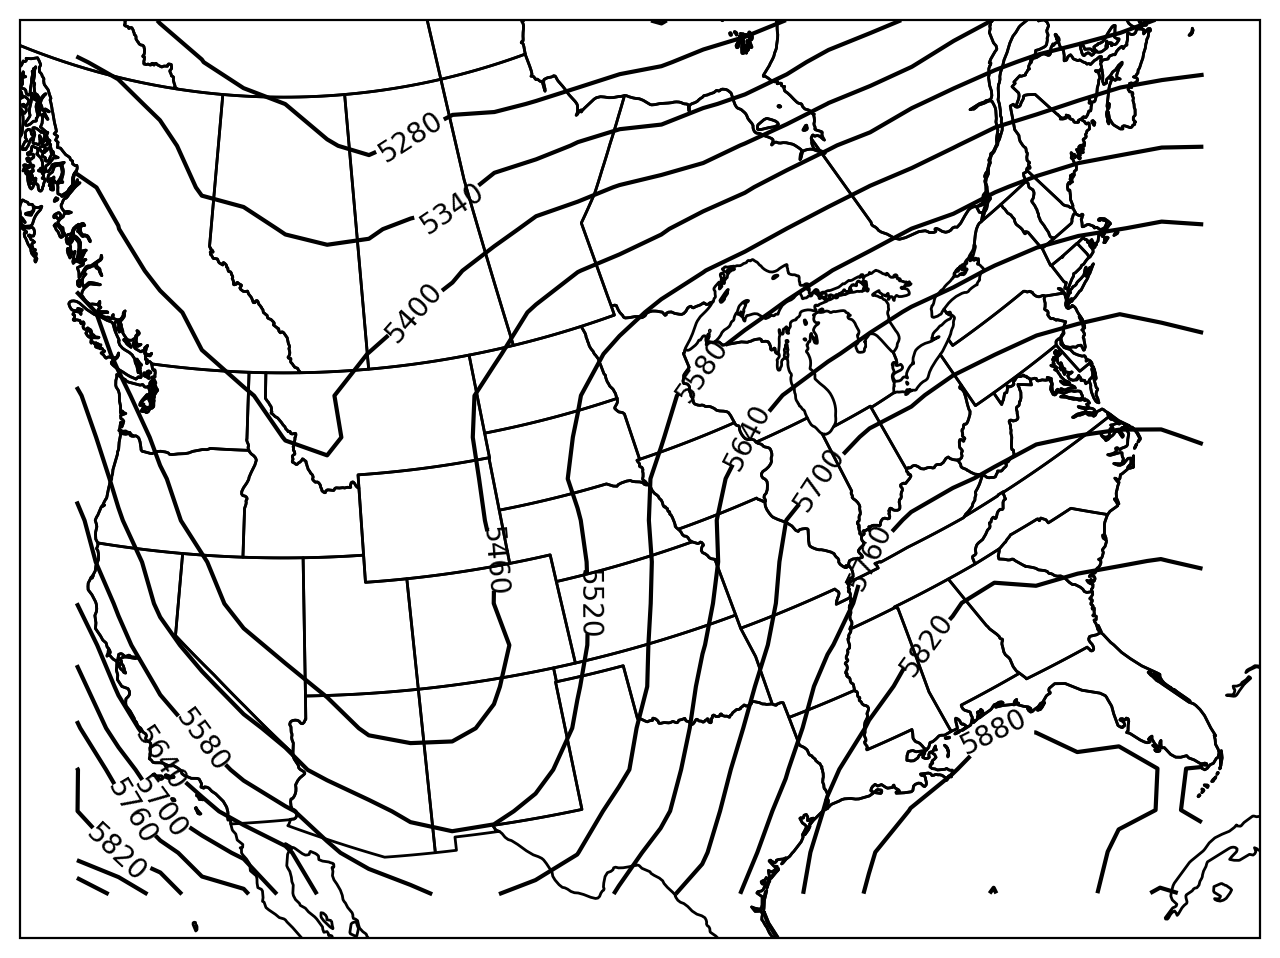

In [10]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid,Lat_Grid,Output10,colors='k', levels=np.arange(0,8000,60), transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.savefig("500mb_Analysis_ROI20.PNG", dpi = 250)

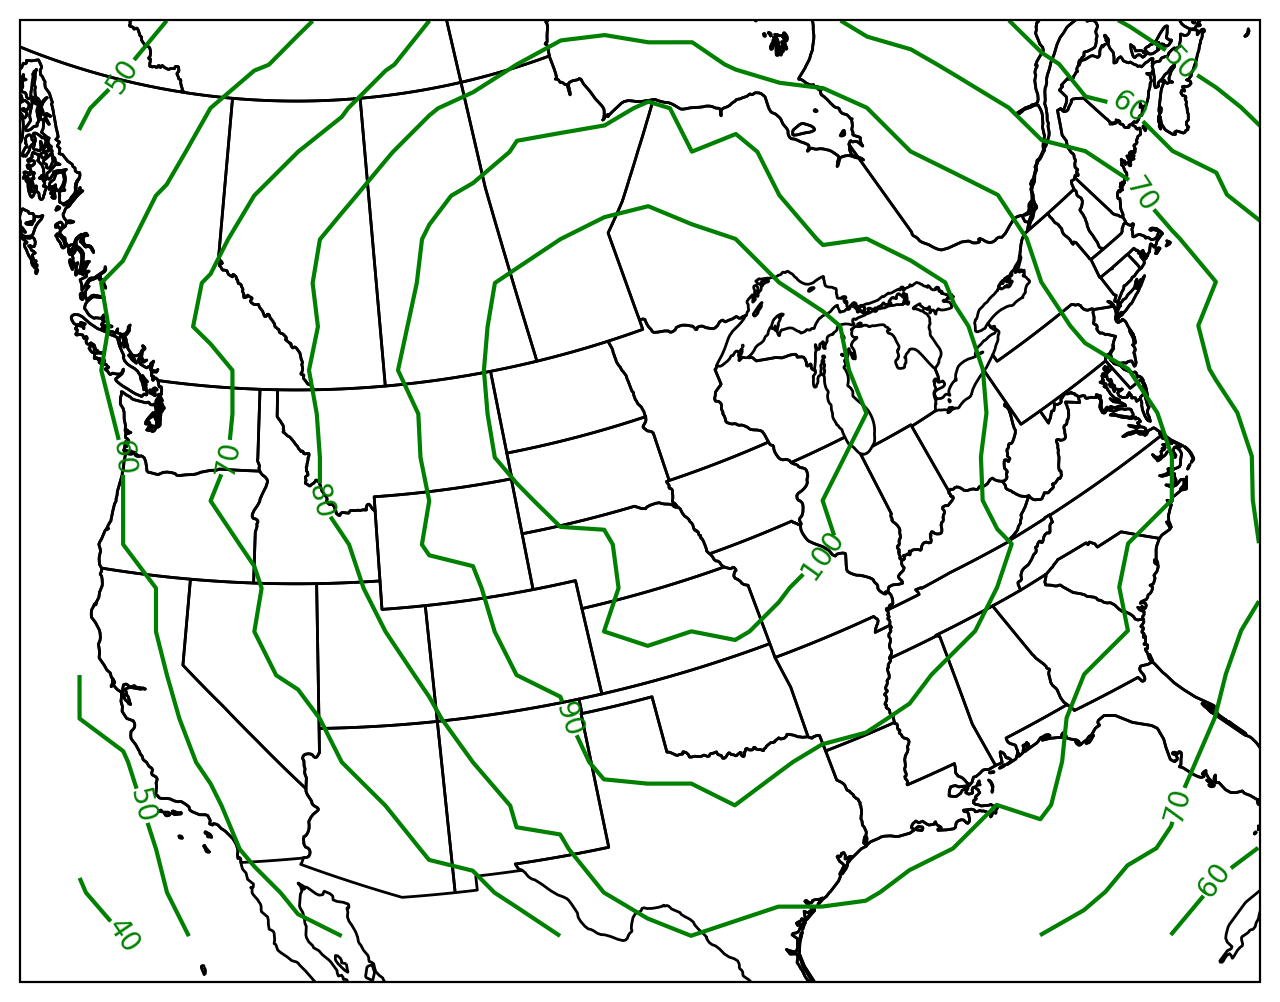

In [49]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_Grid, Lat_Grid, Delobs20, colors='Green', transform=ccrs.PlateCarree())
ax1.clabel(cs1)
plt.savefig("Polynomialfit_ROI20.PNG", dpi = 250)

In [53]:
### Store the analyses in text files ###

np.savetxt("500mb_Analysis_ROI10.txt",Output10)
np.savetxt("500mb_Analysis_ROI20.txt",Output20)

In [54]:
### Store the number of observations available for each grid point in text files ###

np.savetxt("Polynomialfit_ROI10.txt",Delobs10)
np.savetxt("Polynomialfit_ROI20.txt",Delobs20)

In [ ]:
### In a separate text file (or below), answer the following questions ###

'''

1 - Describe the general features that you see in your contoured analyses.
    Large Mid-latitude trough over the western U.S. and a ridge located over the Gulf of
    Mexico and the top of it extending into portions of the Eastern U.S.

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    The 20 cm analysis appears to be smoother than the 10 cm analysis. This could be due to a couple
    of factors. The main factor that I think is responsible is the fact that in the 20 cm analysis,
    there are more stations you end up keeping when you subtract your observations from your grid to
    get the total distance which is used in plotting the analysis. With the smaller ROI of 10 cm, the program has
    to contour in places where there might not be as much data and it struggles to resolve important features
    in the weather pattern.

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them? It does not look realistic and there are a lot of errors due to what I
    had said in my answer to the previous question. Because there are a lot less stations kept in the analysis for
    ROI = 6 cm, it freaked out and didn't look realistic at all in places where there are less observations to begin
    with beforehand (Gulf of Mexico, off the coast of California, and regions of Canada).
    

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
    Absolutely not! you wouldn't have enough data points to do so and because of this, your map wouldn't end
    up being realistic.

'''